In [1]:
using Agents
using InteractiveDynamics
using GLMakie
using Plots
using Random
using Distributions
using Statistics
using StatsBase
using DataFrames, DataFramesMeta


In [2]:
function GiniCoefficientJulia(x)
    n = length(x)
    shift = abs(minimum(x, init=0))
    x = x .+ shift
    # If all values are zero, return 0
    if sum(x) == 0
        return 0
    end
    
    # Sort the values
    x = sort(x)
    
    # Calculate the rank of each value
    rank = collect(1:n)
    
    # Calculate the Gini coefficient using the formula
    return (1 / n) * (2 * sum(rank .* x) / sum(x) - (n + 1))
end


GiniCoefficientJulia (generic function with 1 method)

In [3]:
seed = 123;

MEAN_MONEY = 60_000
SD_MONEY = 5_000;
SHAPE_PARAMETER_XI = 0.5
MONEY_DISTRIBUTION = GeneralizedPareto(MEAN_MONEY, SD_MONEY, SHAPE_PARAMETER_XI)

GeneralizedPareto{Float64}(μ=60000.0, σ=5000.0, ξ=0.5)

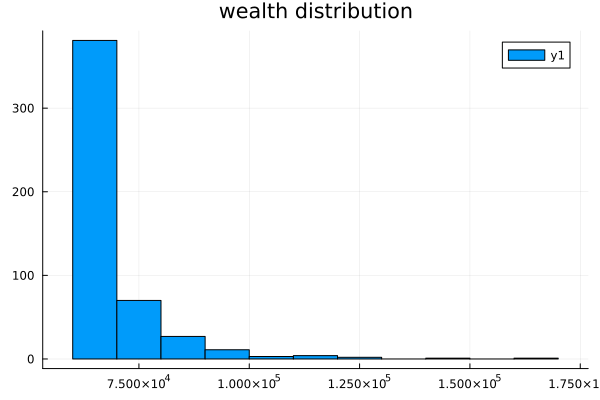

In [4]:
data = [ rand(MONEY_DISTRIBUTION,1)[1] for _ in 1:500 ]
Plots.histogram( data, bins=12, title="wealth distribution" )

In [5]:
@agent SchellingAgent GridAgent{2} begin
    remain::Bool 
    group::Int
    money::Float64
    injection_agent::Bool
    #added to mark the injection agent
    money_change:: Bool
    #added to tell when the agent received money from injection 
    distance_from_injection:: Float64
    #added to update agent position from the injected agent

    potential_energy::Int
    kinetic_energy::Float64 
    
end

In [6]:
seed = 123;

const NN = 30;
const GRID_DIM = (NN,NN);
TOTAL_AGENTS = round( Int, 0.70*prod(GRID_DIM) );

agent_money_gain = 10_000_000

AGENTS_MONEY = rand(MONEY_DISTRIBUTION, TOTAL_AGENTS)
MAX_MONEY = maximum( agent_money_gain );
MOVEMENT_ENERGY_MIN_REQUIREMENT = 0.2
KINETIC_FLOOR = 0.005 #this floor is a threshold to compare against to see if the agent is gaining money

#=
I had to add the kinetic_floor because of several failure attempts at telling when the agent was gaining money from the injection or from its neighbors
1.) firstly, I attempted to do for loops doing the previous step compared to the current step which was not a good coding technique and didn't work
2.) secondly, I attempted to create a store variable in the agent step where I could store the agent.kinetic_energy value before it spent money
    --in theory this is great, but the way that the model works this is not correct. The agent step iterates over all the agents, so the agents kinetic_energy has a high likelihood of changing
    --this is because other agents can move and spend into that same agent changing their kinetic_energy and therefore making their stored kinetic energy no longer valid
3.)thirdly, I attempted to limit the amount of spending by each of the agents (to ~ $500) and compare their money after the injection to this value of $500
    --however, there is no benefit to limmiting their spending and thereby I can just set a floor value to compare against 
=#

KineticEnergy(money) = 2 * money / MAX_MONEY
InvKineticEnergy(kinetic_energy) = (1/2) * MAX_MONEY * kinetic_energy #returns the money and money is then effectively the energy
PotentialEnergy(remain) = 1 * Int( !remain )
FIXED_ENERGY_BINS = 0:0.2:1_000;

In [7]:
scheduler_model = Schedulers.Randomly();

function initialize(; min_to_be_happy_corner = 2,
    min_to_be_happy_inner = 4, 
    min_to_be_happy_side = 3,
    corner_surround = 3,
    inner_surround = 8, 
    side_surround = 5,
    max_distance_from_injection = 0.0, #added a model property to plot the total distance from injection 
    GRID_DIM = GRID_DIM)

    global model_iteration = 0

    space = GridSpaceSingle(GRID_DIM, periodic = false)

    params = Dict(
    :min_to_be_happy_inner => min_to_be_happy_inner, 
    :min_to_be_happy_side => min_to_be_happy_side, 
    :min_to_be_happy_corner => min_to_be_happy_corner,
    :inner_surround => inner_surround, 
    :side_surround => side_surround, 
    :corner_surround => corner_surround,
    :max_distance_from_injection => max_distance_from_injection,
    # :MOVEMENT_ENERGY_MIN_REQUIREMENT => MOVEMENT_ENERGY_MIN_REQUIREMENT
    )

    properties = params

    rng = Random.Xoshiro(seed)

    model = UnremovableABM(SchellingAgent, space; rng=rng, properties=properties, 
                            scheduler=scheduler_model)

    for ii in 1:TOTAL_AGENTS
        remain_i = false
        identity_i = ii < TOTAL_AGENTS/2 ? 1 : 2
        money_i = 0
        injection_agent = false
        money_change = false
        distance_from_injection = 0
        
        potential_energy_i = PotentialEnergy(remain_i)
        kinetic_energy_i = KineticEnergy(money_i)


        agent = SchellingAgent(ii, (1, 1), remain_i, identity_i, money_i,
                                    injection_agent, money_change, distance_from_injection, 
                                    potential_energy_i, kinetic_energy_i)
        add_agent_single!(agent, model)
    end
    return model
end

initialize (generic function with 1 method)

In [8]:
model = initialize()

UnremovableABM with 630 agents of type SchellingAgent
 space: GridSpaceSingle with size (30, 30), metric=chebyshev, periodic=false
 scheduler: Agents.Schedulers.Randomly
 properties: max_distance_from_injection, corner_surround, min_to_be_happy_side, side_surround, inner_surround, min_to_be_happy_inner, min_to_be_happy_corner

In [9]:
function GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group)
    
    #agent moves it remain is false and kinetic is higher than potential
    kinetic_higher_than_potential = agent.kinetic_energy > MOVEMENT_ENERGY_MIN_REQUIREMENT #PotentialEnergy(agent.remain)
    
    remain = true

    if count_near == model.inner_surround && count_neighbors_same_group >= model.min_to_be_happy_inner
        remain = true
    elseif count_near == model.side_surround && count_neighbors_same_group >= model.min_to_be_happy_side
        remain = true
    elseif count_near == model.corner_surround && count_neighbors_same_group >= model.min_to_be_happy_corner
        remain = true
    else
        remain = false
    end
    
    if( kinetic_higher_than_potential == true && remain == false )
        return false
    else
        return true
    end    
    
end

GetAgentRemainStatus (generic function with 1 method)

In [10]:
function MovementMoneySpending(agent, model)
    
    money_spent = InvKineticEnergy(MOVEMENT_ENERGY_MIN_REQUIREMENT)
    
    if( money_spent >= agent.money )
        return
    else
        agent.money -=  money_spent
    end
    
    
    agent.kinetic_energy = KineticEnergy(agent.money)
    
    number_of_neighbors = length( collect( nearby_agents( agent, model ) ) )
    neighbor_dividend = money_spent / number_of_neighbors
    # modify to have only 1 agent receive all the quanta of money
    for neighbor in nearby_agents( agent, model )
        neighbor.money += neighbor_dividend
        neighbor.kinetic_energy = KineticEnergy(neighbor.money)
    end
    
end

MovementMoneySpending (generic function with 1 method)

In [11]:
function MoneySpending(agent, model)
    money_spent = agent.money * 0.00
    
    agent.money -=  money_spent
    agent.kinetic_energy = KineticEnergy(agent.money)
    
end

MoneySpending (generic function with 1 method)

In [43]:
function agent_step!(agent, model)

    agent_golden = model[1]
    #added a chosen one that gets the glorious lump sum of cash injection which chooses it by the id=1

    if agent.injection_agent == true
        agent.injection_agent = true
    end

    if agent_golden.money > 10_000
        agent_golden.injection_agent = true
    end

    #changes the Bool for the golden agent to true

    count_near = 0
    for pos in nearby_positions( agent.pos , model )
        count_near += 1
    end
    
    count_neighbors_same_group = 0    

    for neighbor in nearby_agents( agent, model )
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end

    agent.remain = GetAgentRemainStatus(agent, model, count_near, count_neighbors_same_group) 
    agent.potential_energy = PotentialEnergy( agent.remain )
    
    if agent.remain == false
        randomwalk!(agent, model, 1)
        #walks the agent within his immediate neighbors (3 by 3)
        #if using r=2 this will include a (5 by 5)
        MovementMoneySpending(agent, model)
    end

    MoneySpending(agent, model)


    #=
    -the below is added to update the money_change status of the agent after the injection takes places
    -it will change the Bool to true if their kinetic_energy is greater than the floor set in the constants section 
    -this then will return the euclidean distance from the injected agent as an agent property 
    =#
    
    if model_iteration ≥ 300 && agent.kinetic_energy ≥ KINETIC_FLOOR
        agent.money_change = true
        agent.distance_from_injection = euclidean_distance(agent.pos, agent_golden.pos, model)
    end

    

end

agent_step! (generic function with 1 method)

In [13]:
function ModelRemainTrajectory(model)
    remain = 0
    for agent in allagents(model)
        remain += agent.remain 
    end
    return remain / nagents(model)
end

ModelRemainTrajectory (generic function with 1 method)

In [14]:
function ModelFinancialDisparity(model)
    disparity = 0
    for agent in allagents(model)
        
        disparity_temp = 0
        number_of_neighbors = length( collect( nearby_agents(agent, model, 1) ) )
        
        for neighbor in nearby_agents(agent, model, 1)
            disparity_temp += abs( agent.money - neighbor.money )
        end
        
        if( number_of_neighbors > 0 )
            disparity_temp = disparity_temp / number_of_neighbors
            disparity += disparity_temp
        end

    end
    return disparity
end

ModelFinancialDisparity (generic function with 1 method)

In [15]:
function ModelEntropy(model)
    
    agent_energies = Float64[]
    
    for agent in allagents(model)
        agent_energy = agent.kinetic_energy + agent.potential_energy 
        push!(agent_energies, agent_energy)
    end
    energy_hist = fit(Histogram, agent_energies, FIXED_ENERGY_BINS)
    energy_weights = energy_hist.weights
    nonzero_weights = filter(!iszero, energy_weights)
    energy_probabilities = nonzero_weights ./ sum(nonzero_weights)

    SS = 0
    for ii in 1:length( energy_probabilities )
        SS += (-1) * energy_probabilities[ii] * log( energy_probabilities[ii] )
    end
    
    return SS
end

ModelEntropy (generic function with 1 method)

In [16]:
function ModelInternalEnergy(model)
    # U = sum_distinct_states_i p_i * E_i
    
    agent_energies = Float64[]
    
    for agent in allagents(model)
        agent_energy = agent.kinetic_energy + agent.potential_energy
        push!(agent_energies, agent_energy)

    end
    
    energy_hist = fit(Histogram, agent_energies, FIXED_ENERGY_BINS)
    energy_probabilities = energy_hist.weights ./ sum(energy_hist.weights)
    energy_edges = collect( energy_hist.edges[1] )
    energy_values = [ (energy_edges[i]+energy_edges[i+1])/2 for i in 1:length(energy_edges)-1 ]
    
    UU = 0
    for ii in 1:length(energy_values)
        UU += energy_probabilities[ii] * energy_values[ii]
    end
    
    return UU
end

ModelInternalEnergy (generic function with 1 method)

In [17]:
function ModelInjectionDistance(model)

    #=
        -this function is to update the model property of max_distance_from_injection which takes the maximum distance of the current agent step
          and updates the property if it is greater than the previous step's distance 
        -I am only interested in the maximum distance from the epicenter on a per step basis 
    =#
    max_distance = 0.0

    for agent in allagents(model)

        max_distance = maximum(agent.distance_from_injection)

        if model.max_distance_from_injection < max_distance
            model.max_distance_from_injection = max_distance
        end

    end
    
end

ModelInjectionDistance (generic function with 1 method)

In [18]:
model = initialize()

UnremovableABM with 630 agents of type SchellingAgent
 space: GridSpaceSingle with size (30, 30), metric=chebyshev, periodic=false
 scheduler: Agents.Schedulers.Randomly
 properties: max_distance_from_injection, corner_surround, min_to_be_happy_side, side_surround, inner_surround, min_to_be_happy_inner, min_to_be_happy_corner

10000000

In [19]:
model_iteration = 0;

function model_step!(model)

    global model_iteration += 1

    agent_golden = model[1]

    if( model_iteration % 300 == 0 && model_iteration != 0 )
        agent_golden.money += agent_money_gain
        agent_golden.kinetic_energy = KineticEnergy(agent_golden.money)       
    end

end

model_step! (generic function with 1 method)

In [44]:
adata = [ :potential_energy, :kinetic_energy,:distance_from_injection, :money, :money_change, :injection_agent, :remain, :pos, :group]
mdata = [ ModelRemainTrajectory, ModelFinancialDisparity, 
                        ModelEntropy, ModelInternalEnergy, ModelInjectionDistance, :max_distance_from_injection]



model = initialize()

step_num = 1100;
agent_df, model_df = run!(model, agent_step!, model_step!, step_num; adata , mdata)

(693630×11 DataFrame
    Row │ step   id     potential_energy  kinetic_energy  distance_from_inject ⋯
        │ Int64  Int64  Int64             Float64         Float64              ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │     0      1                 1             0.0                       ⋯
      2 │     0      2                 1             0.0
      3 │     0      3                 1             0.0
      4 │     0      4                 1             0.0
      5 │     0      5                 1             0.0                       ⋯
      6 │     0      6                 1             0.0
      7 │     0      7                 1             0.0
      8 │     0      8                 1             0.0
   ⋮    │   ⋮      ⋮           ⋮                ⋮                    ⋮         ⋱
 693624 │  1100    624                 0             0.0                       ⋯
 693625 │  1100    625                 0             0.0
 693626 │  11

In [ ]:
using CSV

CSV.write("C:\\Users\\tyler\\OneDrive\\Desktop\\output.csv", agent_df)

In [21]:
count_true_rows = sum(agent_df[!, :money_change] .== true)

println("Number of true rows: $count_true_rows")

Number of true rows: 24760


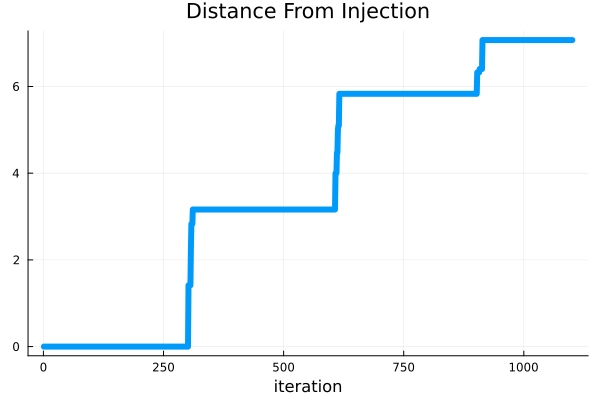

In [22]:
plot_distance = Plots.plot( model_df[!,:max_distance_from_injection], linewidth=6, legend=false,
            title="Distance From Injection", xlabel="iteration" )

In [ ]:
# savefig(plot_distance,"./Plots/Iteration11.pdf")

In [24]:
line_df = subset(model_df, :step => ByRow(≥(300)));
line_df[:, [:step, :max_distance_from_injection]];
line_df2 = subset(line_df, :step => ByRow(≤(310)));
line_df2

Row,step,ModelRemainTrajectory,ModelFinancialDisparity,ModelEntropy,ModelInternalEnergy,ModelInjectionDistance,max_distance_from_injection
,Int64,Float64,Float64,Float64,Float64,Nothing,Float64
1,300,1.0,2.11071e7,0.0118173,0.103175,,0.0
2,301,0.998413,1.85183e7,0.0118173,0.104444,,1.41421
3,302,0.998413,1.70365e7,0.0118173,0.104127,,1.41421
4,303,0.998413,1.55548e7,0.0118173,0.10381,,1.41421
5,304,0.998413,1.4073e7,0.0118173,0.103492,,1.41421
6,305,0.998413,1.25913e7,0.0118173,0.103175,,1.41421
7,306,0.998413,1.26886e7,0.0118173,0.102857,,2.23607
8,307,0.998413,9.74813e6,0.033244,0.103175,,2.82843
9,308,0.992063,1.00966e7,0.0716659,0.109206,,2.82843


In [25]:
x_variable = collect(0:(length(line_df2[!, :max_distance_from_injection])-1));

In [26]:
using Polynomials

In [27]:
# x_variable = len(line_df3[:, :max_distance_from_injection])
x_variable = x_variable
y = line_df2[:, :max_distance_from_injection]
quadfit = Polynomials.fit(x_variable,y,1)

Polynomial(0.5703738577371813 + 0.2669196797938768*x)

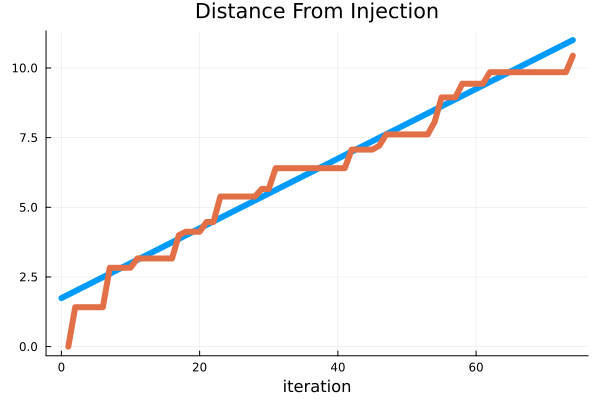

In [58]:
x = 0:1:(length(line_df2[!, :max_distance_from_injection]))

y_equation(x) = 1.739941898400477 +  0.1251531944491129.*x
plot_equation = Plots.plot(x, y_equation, linewidth=6, legend=false,
        title="Rate of Injection", xlabel="iteration")
plot_line = Plots.plot!(line_df2[:, :max_distance_from_injection], linewidth=6, legend=false,
            title="Distance From Injection", xlabel="iteration")

In [ ]:
#=
-iteration 11 the agent wasnt happy at 300, 600, and finally at 900
-rate at 300 0.1020058475846242, rate at 600 0.0017371844489959421, rate at 900 0.016145567233511494, rate of whole iteration 0.0012146404215799117, average 0.039962866422377
=#

In [248]:
#=
the below was done with agents spending @ 5% and min movement energy at 0.5

rate_of_change = [0.29245356364591724, 0.1447322191631609, 0.14079790322432822, 0.26689814780080473, 0.2679772943557236, 0.28318277842580636, 0.3059017324391422, 0.14487812665243416, 0.2753730159422643,
0.3144611362002007, 0.1020058475846242, 0.26076359776923436, 0.30459984420343583, 0.3591865884391319, 0.2972916067107002, 0.11720130547337929, 0.3696172701978934, 0.11848663891697139, 0.24888357763025795,
0.07937354961598428, 0.3830355907810725, 0.10255078224056499, 0.27629831417556083, 0.3077080058789811, 0.319820443912399, 0.35281273448803235, 0.1555186050715807, 0.22607579878450584, 0.19178998895527946,
0.14336287764300978];
=#

#=
The below is the *updated* array based on no spending and min movement energy at 0.2 (from the original model)
=#

rate_of_change = [0.15421008628103045, 0.3582212152286905, 0.18135143385670743, 0.3782288503436638, 0.1251531944491129, 0.2150151025131334,  0.2651958356997823, 0.28453231270825763, 0.2976847609102302,
0.3582212152286905, 0.17530669373974173, 0.17183443288812852, 0.08709512456336774, 0.27716982793927364, 0.3504810669532772, 0.35131765585580566, 0.25566992240246955,  0.2858008672724287, 0.1280860127654778,
0.24473443619553062, 0.32593463263230354, 0.2992084999590296, 0.18088231958472484, 0.2653655829370381, 0.33734536165374845, 0.18019233797639425, 0.3525756294951886, 0.3384759103204772, 0.18589178519022118,
0.21490957104717204];

In [250]:
ROC_average = mean(rate_of_change);
ROC_std = std(rate_of_change);

println("The rate of change average per 30 simulations is: $ROC_average
The standard deviation of the 30 simulations is: $ROC_std")

The rate of change average per 30 simulations is: 0.2542030559530366
The standard deviation of the 30 simulations is: 0.08276643170541124


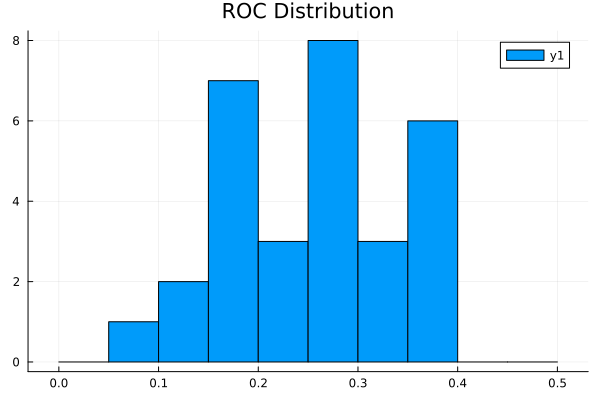

In [255]:
ROC_distribution = Plots.histogram( rate_of_change, bins=0:0.05:0.5, title="ROC Distribution" )

ROC_distribution
# savefig(ROC_distribution,"./Plots/ROC_distribution.pdf")

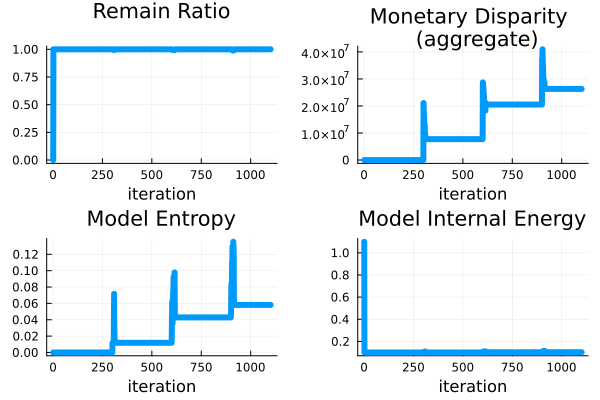

In [28]:
p1 = Plots.plot( model_df[!,:ModelRemainTrajectory], linewidth=6, legend=false, 
title="Remain Ratio", xlabel="iteration" )
p2 = Plots.plot( model_df[!,:ModelFinancialDisparity], linewidth=6, legend=false,
            title="Monetary Disparity \n (aggregate)", xlabel="iteration" )
p3 = Plots.plot( model_df[!,:ModelEntropy], linewidth=6, legend=false,
            title="Model Entropy", xlabel="iteration" )
p4 = Plots.plot( model_df[!,:ModelInternalEnergy], linewidth=6, legend=false,
            title="Model Internal Energy", xlabel="iteration" )


pOveral = Plots.plot([p1,p2,p3,p4]..., layout=grid(2,2) )

In [29]:
gini_internal_U = []
gini_kinetic = []
percentage_remain = []
kinetic_means = []

Any[]

In [30]:
for step in 1:step_num
    agent_U_vals = agent_df[isequal.(agent_df.step, step), :][!,:potential_energy]
    gini = GiniCoefficientJulia( agent_U_vals )
    push!(gini_internal_U,gini)
    push!(percentage_remain, length( findall( agent_U_vals .== 0 ) ) / TOTAL_AGENTS )
    
    agent_K_vals = agent_df[isequal.(agent_df.step, step), :][!,:kinetic_energy]
    agent_K_groups = (KineticEnergy(MAX_MONEY)/100) .* div.(agent_K_vals, KineticEnergy(MAX_MONEY)/100 ) 
    
    if( length(findall( agent_K_vals .< 0 )) > 0 )
        println("BAD")
        println(agent_K_vals)
    end
    gini = GiniCoefficientJulia( agent_K_groups )
    push!(gini_kinetic,gini)
    push!(kinetic_means, mean(agent_K_vals))
end

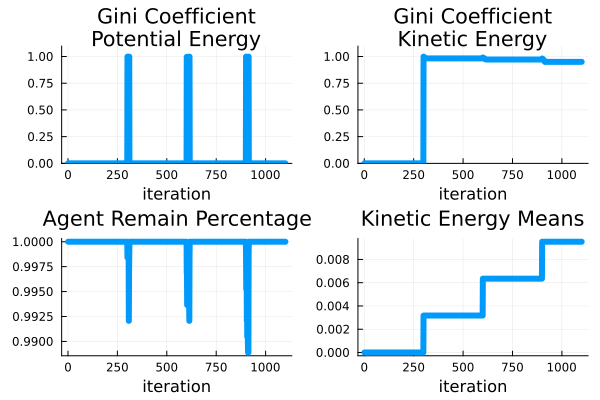

In [31]:
p1_gini = Plots.plot(gini_internal_U, linewidth=6, legend=false,
            title="Gini Coefficient\nPotential Energy", xlabel="iteration",
            ylim=ylim=[0,maximum(gini_internal_U)*1.1])
p2_gini = Plots.plot(gini_kinetic, linewidth=6, legend=false,
                title="Gini Coefficient\nKinetic Energy", xlabel="iteration",
                ylim=[0,maximum(gini_kinetic)*1.1])
p3_gini = Plots.plot(percentage_remain, linewidth=6, legend=false,
                title="Agent Remain Percentage", xlabel="iteration" )
p4_gini = Plots.plot(kinetic_means, linewidth=6, legend=false,
                title="Kinetic Energy Means", xlabel="iteration" )
p_gini = Plots.plot([p1_gini,p2_gini,p3_gini,p4_gini]...,layout=grid(2,2))

In [32]:
using Colors
using ColorSchemes

In [33]:
function number_to_thermal_color(n::Bool)
    color_scheme = ColorSchemes.thermal
    # Use the number to get a color from the scheme
    color = get(color_scheme, n)    
    return color
end

number_to_thermal_color (generic function with 1 method)

In [34]:

function FinanceColor(agent) 
    money_change = agent.money_change
    return number_to_thermal_color(money_change)
end

FinanceColor (generic function with 1 method)

In [35]:
groupcolor(a) = a.group == 1 ? :blue : :orange
groupmarker(a) = a.injection_agent == true ? :circle : :rect

groupmarker (generic function with 1 method)

In [37]:
using CairoMakie

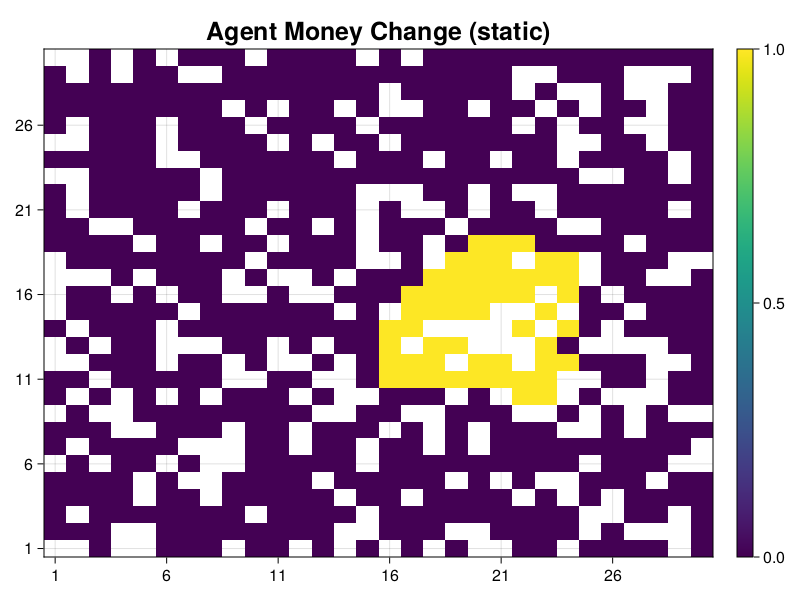

In [38]:
agent_money(xx,yy) = id_in_position( (xx,yy) , model ) > 0 ? model[ id_in_position( (xx,yy) , model ) ].money_change : NaN

xs = 1:30
ys = 1:30

fig, ax, hm = CairoMakie.heatmap(xs, ys, agent_money, 
                                    axis = (; title = "Agent Money Change (static)", titlesize=25, xticks=(1:5:NN), yticks=(1:5:NN)) )
Colorbar(fig[:, end+1], hm)

fig

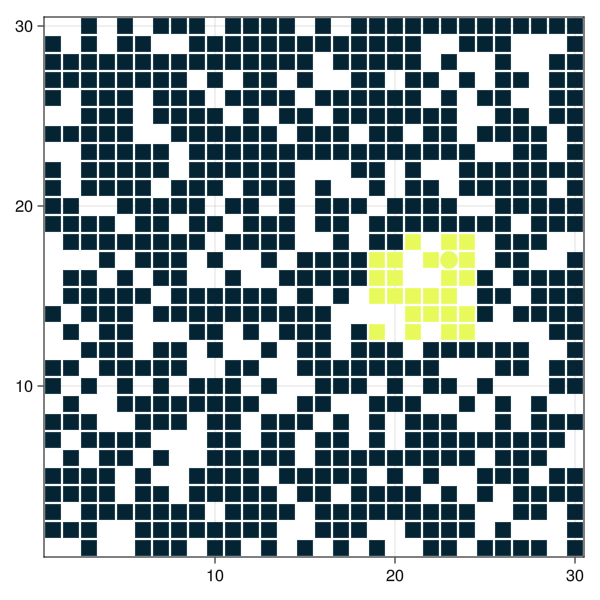

In [47]:

figure, _ = Agents.abmplot( model ; ac = FinanceColor, am = groupmarker, as = 25,
                figure = (; resolution = (600,600)) )
figure

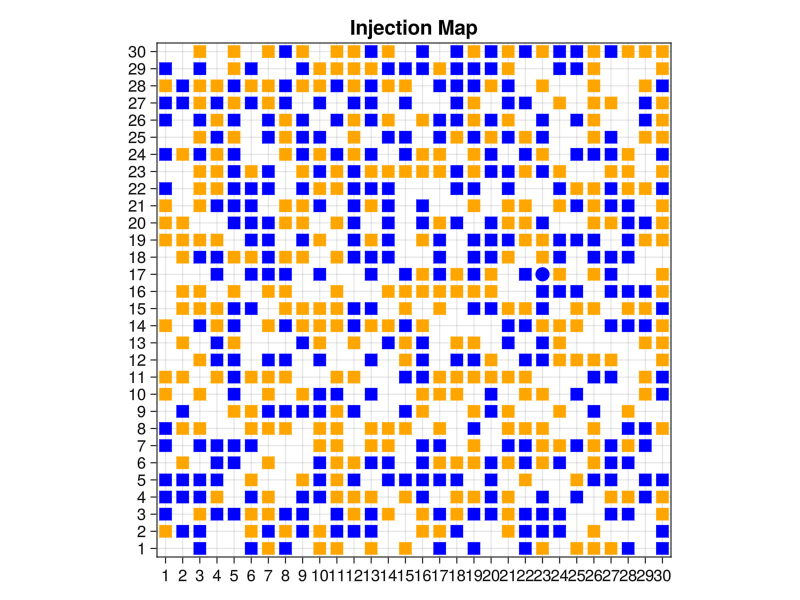

In [48]:
injection_map, _ = Agents.abmplot( model ; ac = groupcolor, am = groupmarker, as = 20,
                            axis = (; title = "Injection Map", titlesize=20, xticks=(1:1:30), yticks=(1:1:30)))
injection_map



In [46]:
GLMakie.activate!(inline=true)

In [42]:
model = initialize()

fig, _ = Agents.abmexploration(model; 
                agent_step!,
                model_step!,
                ac=FinanceColor, am=groupmarker, as = 20,
                figure=(;resolution=(600,600))
                )
display(fig)

GLMakie.Screen(...)